<a href="https://colab.research.google.com/github/carrol23/at_texture/blob/main/ref_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd gdrive/MyDrive/data

[Errno 2] No such file or directory: 'gdrive/MyDrive/data'
/content/gdrive/MyDrive/data


In [ ]:
!pip install rioxarray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install rasterstats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import geopandas as gpd
from osgeo import gdal, gdal_array
from osgeo import osr
import rasterio
import rioxarray
import numpy as np
import matplotlib.pyplot
import pandas as pd
import rasterstats as rs
import datetime
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, balanced_accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, ShuffleSplit, KFold
from sklearn.tree import DecisionTreeClassifier

In [ ]:
input_data = gpd.read_file('ref-tree-class.geojson')
input_data

,idlcass,geometry
0,1,POINT (416347.285 8466874.095)
1,1,POINT (417209.203 8466313.833)
2,0,POINT (416677.920 8466469.453)
3,0,POINT (417922.270 8466480.406)
4,1,POINT (417978.859 8466390.655)
...,...,...
94,0,POINT (417782.773 8466705.384)
95,0,POINT (417592.349 8466857.656)
96,0,POINT (417620.267 8466837.301)
97,0,POINT (417609.478 8466829.849)


#### Read in Rasters - stack, write and read again

In [ ]:
file_ls = ['fDHMrough.tif', 'DSMrough.tif', 'lapDHMrough.tif', 'DSMslp.tif', 'DEMslp.tif']

# read metadata for the first file
with rasterio.open(file_ls[0]) as src0:
  meta = src0.meta

# update to the total no of layers
meta.update(count = len(file_ls))

# stack raster from list and write
with rasterio.open('stck.tif', 'w', **meta) as dst:
  for id, layer in enumerate(file_ls, start=1):
    with rasterio.open(layer) as src1:
      dst.write_band(id, src1.read(1))
    dst.descriptions = tuple(['fDHMrough', 'DSMrough', 'lapDHMrough', 'DSMslp', 'DEMslp'])

In [ ]:
stck = gdal.Open('stck.tif', gdal.GA_ReadOnly)

In [ ]:
stck1 = rasterio.open('stck.tif')

In [ ]:
stck_x = rioxarray.open_rasterio('stck.tif')
stck_x # check xarray of stacked bands
# print(stck_x.rio.crs)

<xarray.DataArray (band: 5, y: 1000, x: 2000)>
[10000000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3 4 5
  * x            (x) float64 4.16e+05 4.16e+05 4.16e+05 ... 4.18e+05 4.18e+05
  * y            (y) float64 8.467e+06 8.467e+06 ... 8.466e+06 8.466e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('fDHMrough', 'DSMrough', 'lapDHMrough', 'DSMslp', 'DEMslp')

In [ ]:
# check count, metadata and descriptions
bcount = stck1.count
tags = stck1.tags()
#desc = stck.GetDescription

In [ ]:
# print desc and metadata
# print('Raster description: {desc}\n'.format(desc=desc))
print('Raster tag: \n', tags)
print('No. of bands:\n', bcount)

Raster tag: 
 {'AREA_OR_POINT': 'Area'}
No. of bands:
 5


In [ ]:
img = np.zeros((stck.RasterYSize, stck.RasterXSize, stck.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(stck.GetRasterBand(1).DataType))

In [ ]:
print(img[1])

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [ ]:
for b in range(img.shape[2]):
  img[:,:,b] = stck.GetRasterBand(b+1).ReadAsArray()

print(img.shape)

(1000, 2000, 5)


In [ ]:
X_img = img[:,:,:5].reshape(2000000, 5)

print(X_img.shape) # is a numpy ndarray

(2000000, 5)


In [ ]:
coordinates_index = range(len(input_data))
df_ = pd.DataFrame({"Index":coordinates_index})
#df_ = df_.fillna(0)
df_

for zstat in range(bcount):
        # zonal statistics
        zs = rs.zonal_stats(input_data, file_ls[zstat], stats=['mean'])
        display("-----")
        name_field = file_ls[zstat]
        #df[name_field]
        stats_df = pd.DataFrame(zs)
        stats_df.rename(columns={'mean':name_field}, inplace=True)
        df_ = pd.concat([stats_df, df_], axis = 1)
        grids_gdf = pd.concat([input_data, df_], axis=1) # concat grid results, coords and class results

'-----'

'-----'

'-----'

'-----'

'-----'

In [ ]:
# get raster values only - use df_
# drop columns
grid_gdf = grids_gdf.drop(columns = {'geometry', 'Index'})
grid_gdf = grid_gdf.rename(columns = {'idlcass':'class'})

In [ ]:
class_dict = {'tree': 1, 'other': 0}
field = 'class'
# get column names from header
column_names = []
for col in grid_gdf.columns:
  column_names.append(col)

model_col_indices = [
    column_names.index(var_name) for var_name in column_names[1:]
]

print(model_col_indices)

[1, 2, 3, 4, 5]


In [ ]:
column_names

['class',
 'DEMslp.tif',
 'DSMslp.tif',
 'lapDHMrough.tif',
 'DSMrough.tif',
 'fDHMrough.tif']

In [ ]:
# convert coordinates df to numpy array
coordinates_np = grid_gdf.to_numpy()
# convert variable names to scikit learn nomenclature
X1 = coordinates_np[:, model_col_indices]
y1 = coordinates_np[:,0]

In [ ]:
dfs = {}

# Insert data into a Pandas DataFrame, then split into features and labels
X = grid_gdf.drop(field, axis=1)
y = grid_gdf[[field]]

# Fit the standard scaler to all features
scaler = StandardScaler(with_mean=False)
scaler.fit(X);

for key, value in class_dict.items():
    print(key, value)
    # extract values for class from training data
    # create a pandas df for ease of use later
    df = grid_gdf.rename(columns={i:column_names[i] for i in range(0,len(column_names))}).drop(field, axis=1)
    # Scale the dataframe
    scaled_df = scaler.transform(df)
    scaled_df = pd.DataFrame(scaled_df, columns=df.columns)

    dfs.update({key:scaled_df})

tree 1
other 0


### Get Feature Importance from Training Samples

In [ ]:
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestClassifier

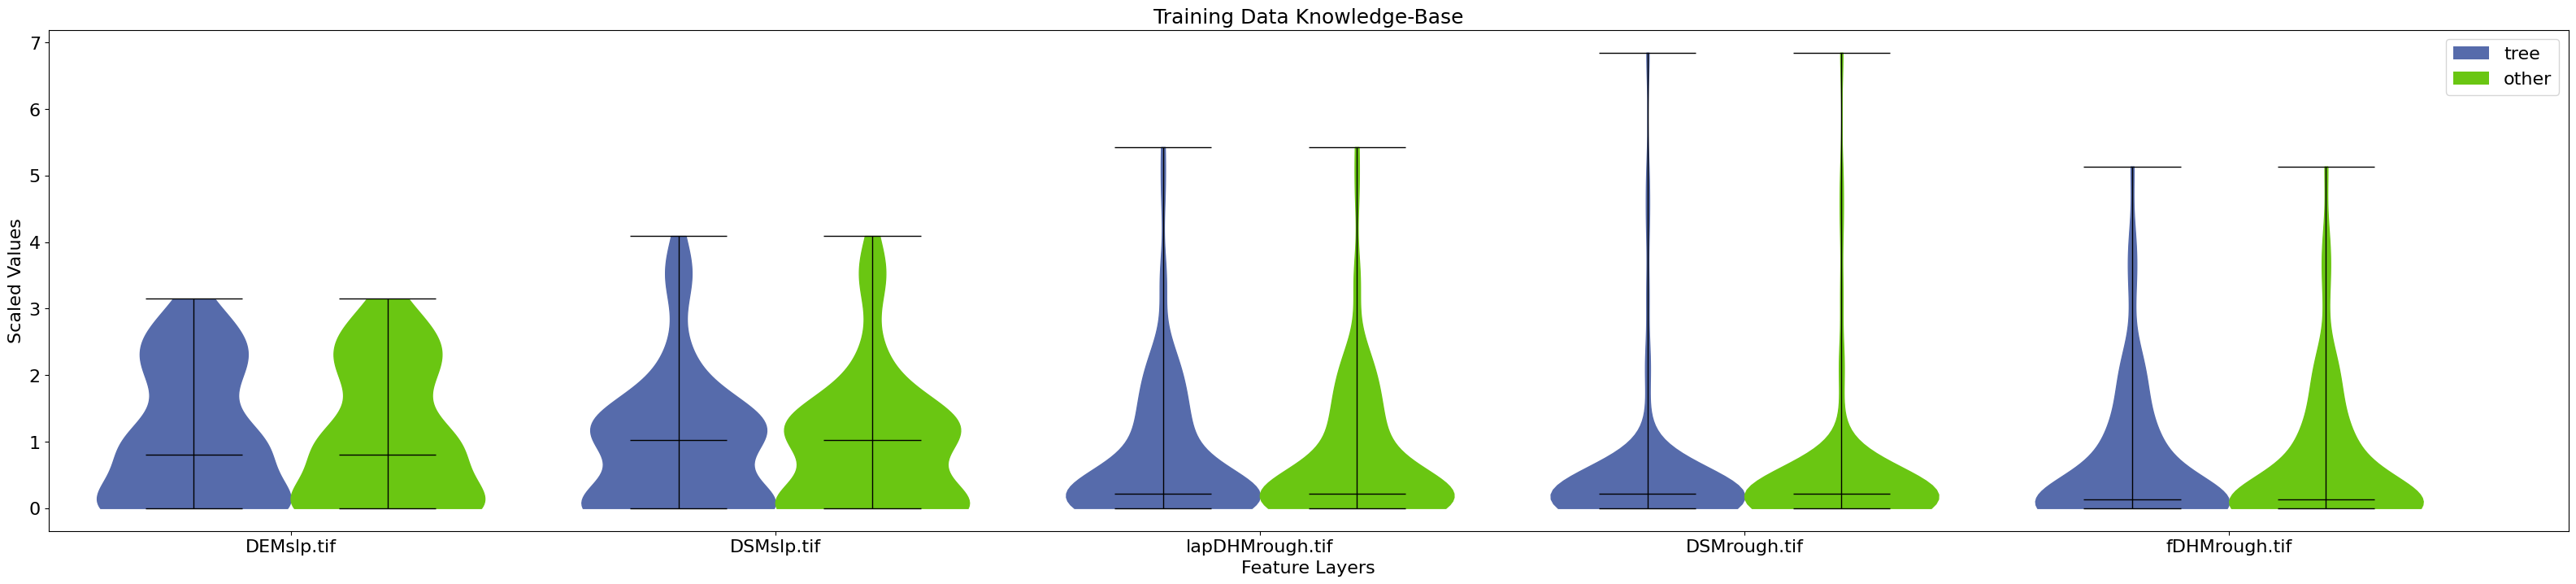

In [ ]:
# Generate a random list of colors same length as num of classes (2 classe so 2 colours)
get_colors = lambda n: list(
    map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF), range(n)))
colors = get_colors(len(dfs))

# Generate list of offsets & widths for plotting
start = -0.2
end = 0.2
offsets = list(np.linspace(start, end, len(dfs)))
if len(dfs) == 2:
    width = 0.4
else:
    width = np.abs(offsets[0] - offsets[1])

# Create figure and axes
fig, ax = plt.subplots(figsize=(40, 8))

for key, color, offset in zip(dfs, colors, offsets):
    # Create violin plots
    pp = ax.violinplot(dfs[key].values,
                       showmedians=True,
                       positions=np.arange(dfs[key].values.shape[1]) + offset,
                       widths=width)
    # Change the colour of the plots
    for pc in pp['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor(color)
        pc.set_alpha(1)

    # Change the line style in the plots
    for partname in ('cbars', 'cmins', 'cmaxes', 'cmedians'):
        vp = pp[partname]
        vp.set_edgecolor('black')
        vp.set_linewidth(1)

# Tidy the plot, add a title and legend
ax.set_xticks(np.arange(len(column_names[1:])))
ax.set_xticklabels(column_names[1:])
ax.set_xlim(-0.5, len(column_names[1:]) - .3)
ax.set_ylabel("Scaled Values", fontsize=16)
ax.set_xlabel("Feature Layers", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title("Training Data Knowledge-Base", fontsize=18)
ax.legend([Patch(facecolor=c) for c in colors], [key for key in dfs],
          loc='upper right',
          fontsize=16);

In [ ]:
model=RandomForestClassifier(random_state=42)
model.fit(X, y.values.ravel());

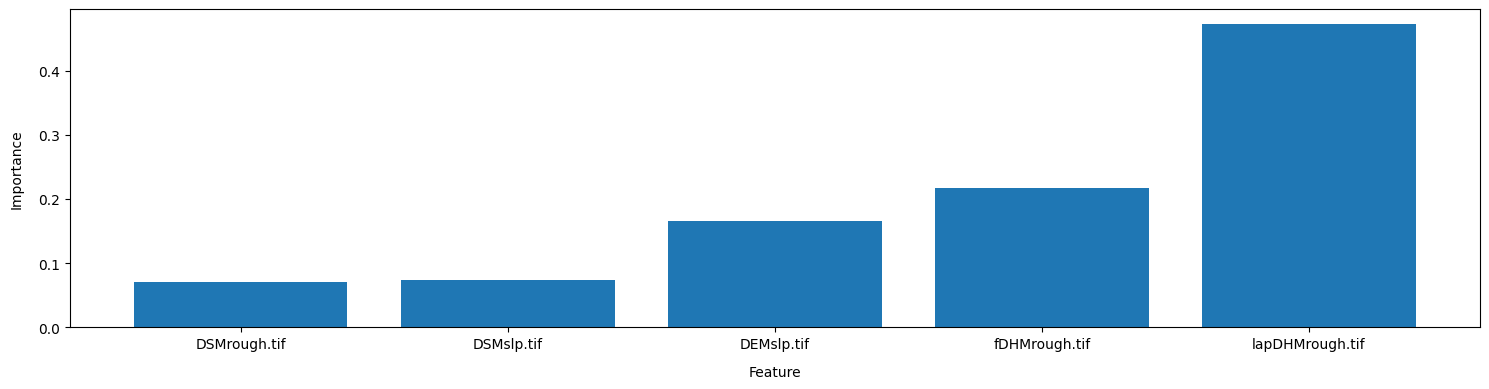

In [ ]:
# plot feature importance
order = np.argsort(model.feature_importances_)

plt.figure(figsize=(15, 4))
plt.bar(x=np.array(column_names[1:])[order],
        height=model.feature_importances_[order])
plt.gca().set_ylabel('Importance', labelpad=10)
plt.gca().set_xlabel('Feature', labelpad=10)
plt.tight_layout()

# bands fDHM roughness and DEM slope are most important

### Split Data into Test and Train

In [ ]:
from pprint import pprint

Classifier = RandomForestClassifier
metric = 'balanced_accuracy'

# k-fold cross validation analysis
inner_cv_splits = 5
outer_cv_splits = 5
test_size = 0.20 # fract of dataset set aside

In [ ]:
# Create the parameter grid based on the results of random search
param_grid = {
    'class_weight': ['balanced', 'balanced_subsample', None],
    'max_features': ['sqrt', 'log2', None],
    'n_estimators': [20, 45, 65],
    'criterion': ['gini', 'entropy', 'log_loss']
}

In [ ]:
# Generate n_splits of train-test_split
rs = ShuffleSplit(n_splits=outer_cv_splits, test_size=test_size, random_state=0)

clf = GridSearchCV(Classifier(),
                   param_grid,
                   scoring=metric,
                   verbose=1,
                   cv=rs.split(X1, y1))

clf.fit(X1,y1)

print('\n')
print("The most accurate combination of tested parameters is: ")
pprint(clf.best_params_)
print('\n')
print(f"The {metric} score using these parameters is: ")
print(round(clf.best_score_, 2))

Fitting 5 folds for each of 81 candidates, totalling 405 fits


The most accurate combination of tested parameters is: 
{'class_weight': 'balanced_subsample',
 'criterion': 'log_loss',
 'max_features': 'sqrt',
 'n_estimators': 65}


The balanced_accuracy score using these parameters is: 
0.91


In [ ]:
# Create a new model
new_model = Classifier(**clf.best_params_, random_state=1)
new_model.fit(X1, y1)

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       n_estimators=65, random_state=1)

In [ ]:
rf_pred = new_model.predict(X_img)

In [ ]:
# get shape and re-shape
rf_pred.shape
rf_feat = rf_pred.reshape(1000, 2000)
#rf_feat = rf_feat[..., np.newaxis]

In [ ]:
rf_feat.shape

(1000, 2000)

In [ ]:
with rasterio.open('DEMslp.tif') as src:
  ras_data = src.read()
  ras_meta = src.profile

print(ras_meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 2000, 'height': 1000, 'count': 1, 'crs': CRS.from_epsg(32702), 'transform': Affine(1.0, 0.0, 416000.0,
       0.0, -1.0, 8467000.0), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}


In [ ]:
ras_data.shape

(1, 1000, 2000)

In [ ]:
with rasterio.open('rf_output.tif', 'w', **ras_meta) as dst:
  dst.write(rf_feat, indexes = 1)

#### Plot Output

In [ ]:
# import RF as xarray
rf_pred = rioxarray.open_rasterio('rf_output.tif')
rf_pred

<xarray.DataArray (band: 1, y: 1000, x: 2000)>
[2000000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4.16e+05 4.16e+05 4.16e+05 ... 4.18e+05 4.18e+05
  * y            (y) float64 8.467e+06 8.467e+06 ... 8.466e+06 8.466e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0
    scale_factor:   1.0
    add_offset:     0.0

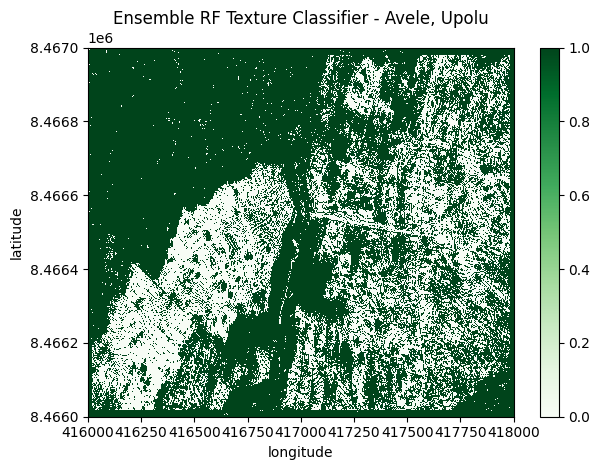

In [ ]:
rf_pred.plot(cmap = plt.cm.Greens)
plt.title("Ensemble RF Texture Classifier - Avele, Upolu")
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.tight_layout()
plt.draw()

### Decision Tree

Run simple decision tree - with best-parameters from RF classifier



In [ ]:
model=DecisionTreeClassifier(random_state=16)
model.fit(X, y.values.ravel());

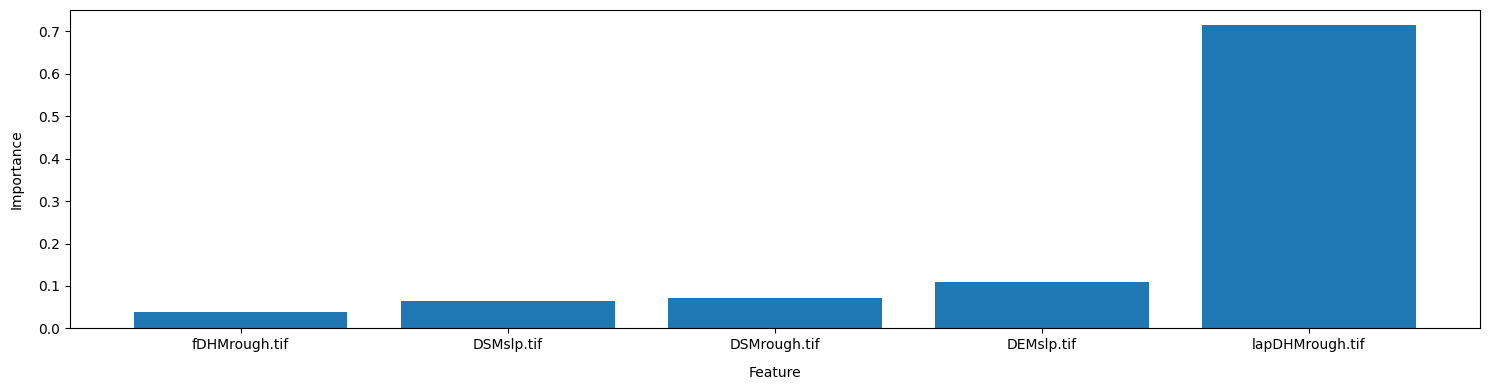

In [ ]:
# plot feature importance
order = np.argsort(model.feature_importances_)

plt.figure(figsize=(15, 4))
plt.bar(x=np.array(column_names[1:])[order],
        height=model.feature_importances_[order])
plt.gca().set_ylabel('Importance', labelpad=10)
plt.gca().set_xlabel('Feature', labelpad=10)
plt.tight_layout()

# bands fDHM roughness and DEM slope are most important

In [ ]:
# split data for decision tree
X_train, X_test, Y_train, Y_test = train_test_split(X1, y1, random_state=0)

In [ ]:
clf = DecisionTreeClassifier(criterion = 'gini', class_weight = 'balanced', random_state = 0) # remove max depth - produced higher accuracy
clf.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=0)

In [ ]:
# predict labels of unseen test data
clf.predict(X_test)

array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 0.])

In [ ]:
# test accuracy
clf.score(X_test, Y_test)

0.92

In [ ]:
from datetime import datetime
now = datetime.now()
print(now)

2023-06-09 06:52:20.172107


#### Predict model onto image

In [ ]:
# predict onto image converted into array, results in a numpy array
dt_pred = clf.predict(X_img)

In [ ]:
# reshape result output
dt_feat = dt_pred.reshape(1000, 2000)
# check shape to export
dt_feat.shape

(1000, 2000)

In [ ]:
# use same metadata output to export array as tif
with rasterio.open('dt_output.tif', 'w', **ras_meta) as dst:
  dst.write(dt_feat, indexes = 1)

## Visualise Output DT

In [ ]:
# import DT as xarray
dt_pred = rioxarray.open_rasterio('dt_output.tif')
dt_pred

<xarray.DataArray (band: 1, y: 1000, x: 2000)>
[2000000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4.16e+05 4.16e+05 4.16e+05 ... 4.18e+05 4.18e+05
  * y            (y) float64 8.467e+06 8.467e+06 ... 8.466e+06 8.466e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0
    scale_factor:   1.0
    add_offset:     0.0

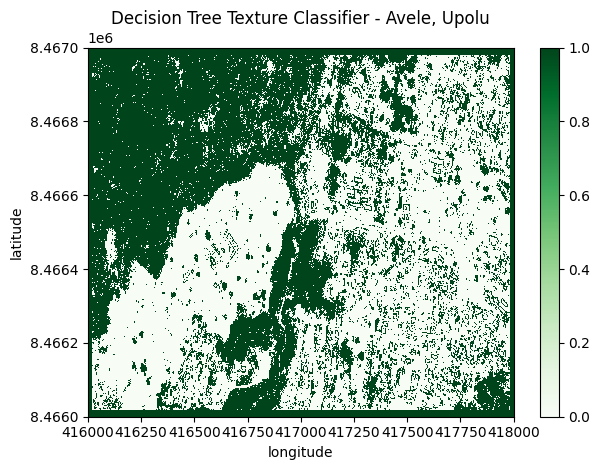

In [ ]:
dt_pred.plot(cmap = plt.cm.Greens)
plt.title("Decision Tree Texture Classifier - Avele, Upolu")
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.tight_layout()
plt.draw()

#### Visualise Tree

[Text(0.4305555555555556, 0.9444444444444444, 'x[2] <= 14.766\ngini = 0.5\nsamples = 74\nvalue = [37, 37]'),
 Text(0.2777777777777778, 0.8333333333333334, 'x[1] <= 40.96\ngini = 0.205\nsamples = 38\nvalue = [32.256, 4.229]'),
 Text(0.2222222222222222, 0.7222222222222222, 'x[2] <= 0.033\ngini = 0.163\nsamples = 37\nvalue = [32.256, 3.171]'),
 Text(0.16666666666666666, 0.6111111111111112, 'gini = 0.0\nsamples = 1\nvalue = [0.0, 1.057]'),
 Text(0.2777777777777778, 0.6111111111111112, 'x[1] <= 17.802\ngini = 0.115\nsamples = 36\nvalue = [32.256, 2.114]'),
 Text(0.2222222222222222, 0.5, 'gini = 0.0\nsamples = 22\nvalue = [20.872, 0.0]'),
 Text(0.3333333333333333, 0.5, 'x[1] <= 24.067\ngini = 0.264\nsamples = 14\nvalue = [11.385, 2.114]'),
 Text(0.2777777777777778, 0.3888888888888889, 'x[0] <= 12.031\ngini = 0.46\nsamples = 6\nvalue = [3.795, 2.114]'),
 Text(0.16666666666666666, 0.2777777777777778, 'x[4] <= 0.5\ngini = 0.428\nsamples = 3\nvalue = [0.949, 2.114]'),
 Text(0.1111111111111111, 0

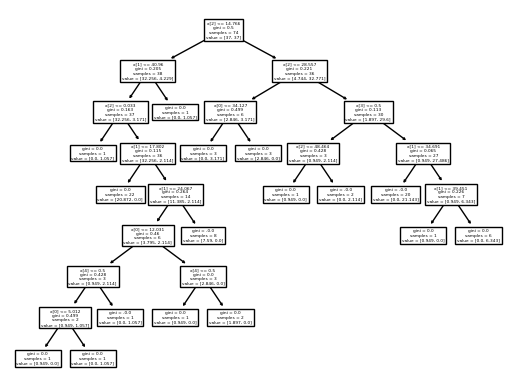

In [ ]:
from sklearn import tree
tree.plot_tree(clf)

### Weight Decision Tree

Weight variables in DT

In [ ]:
#from sklearn.datasets import make_classification
# split data for decision tree
#X_train, X_test, Y_train, Y_test = train_test_split(X1, y1, random_state=0)

In [ ]:
# CART deicsion tree
#clf = tree.DecisionTreeRegressor(max_depth = None, random_state = 1) # remove max depth - produced higher accuracy
#clf.fit(X_train, Y_train)

In [ ]:
# predict labels of unseen test data
#clf.predict(X_test)

In [ ]:
# test accuracy
#clf.score(X_test, Y_test)

In [ ]:
#dtr_pred = clf.predict(X_img)

In [ ]:
# reshape result output
#dtr_feat = dtr_pred.reshape(1000, 2000)
# check shape to export
#dtr_feat.shape

In [ ]:
# use same metadata output to export array as tif
#with rasterio.open('dtr_output.tif', 'w', **ras_meta) as dst:
#  dst.write(dtr_feat, indexes = 1)

In [ ]:
# import DT as xarray
#dtr_pred = rioxarray.open_rasterio('dtr_output.tif')
#dtr_pred

In [ ]:
#dtr_pred.plot(cmap = plt.cm.Greens)
#plt.title("Decision Tree CART Texture Classifier - Avele, Upolu")
#plt.ylabel("latitude")
#plt.xlabel("longitude")
#plt.tight_layout()
#plt.draw()